In [1]:
import pandas as pd
import os

In [2]:
op_list = os.listdir(r'C:\Users\ChastLai\Documents\Data\Option\日收盤\\')
op = pd.read_csv(r'C:\Users\ChastLai\Documents\Data\Option\日收盤\20220101.csv', encoding='big5', index_col=False)
for o in op_list:
    if o == '20220101.csv':
        continue
    data = pd.read_csv(r'C:\Users\ChastLai\Documents\Data\Option\日收盤\\' + o, encoding='big5', index_col=False, dtype=str)
    data = data[data['契約'] == 'TXO']
    op = pd.concat([op, data], axis=0)
op.loc[:, '交易日期'] = pd.to_datetime(op.loc[:, '交易日期'])
op['未沖銷契約數'].replace('-', 0, inplace=True)
op.loc[:, '未沖銷契約數'] = op['未沖銷契約數'].astype(int)

In [3]:
call = pd.read_excel(r'C:\Users\ChastLai\Documents\Data\Option\外資.xlsx', sheet_name='CALL', header=4)
call.set_index('日期', inplace=True)
call.columns = call.columns + '_call'
put = pd.read_excel(r'C:\Users\ChastLai\Documents\Data\Option\外資.xlsx', sheet_name='PUT', header=4)
put.set_index('日期', inplace=True)
put.columns = put.columns + '_put'


In [4]:
group = op.groupby(['交易日期', '到期月份(週別)'], group_keys=True)


In [5]:
import numpy as np
op['CP'] = np.where(op['買賣權']=='買權', 1, -1)
strike_list = list()
op['履約價'] = op['履約價'].astype(float)
for x in range(6000, 19000, 50):
    op.loc[:, str(x)] = (x - op['履約價']) * op['CP'] * op['未沖銷契約數']
    op.loc[:, str(x)].where(op.loc[:, str(x)] > 0, 0, inplace=True) 
    strike_list.append(str(x))

C:\Users\ChastLai\AppData\Local\Temp\ipykernel_8008\4111780607.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  op.loc[:, str(x)] = (x - op['履約價']) * op['CP'] * op['未沖銷契約數']
C:\Users\ChastLai\AppData\Local\Temp\ipykernel_8008\4111780607.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  op.loc[:, str(x)] = (x - op['履約價']) * op['CP'] * op['未沖銷契約數']
C:\Users\ChastLai\AppData\Local\Temp\ipykernel_8008\4111780607.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

In [6]:
maxpain = op.groupby(['交易日期', '到期月份(週別)'])[strike_list].sum()

In [7]:
pain_list = list()
for s in op['到期月份(週別)'].unique():
    for d in op['交易日期'].unique():
        try:
            print(s, d, maxpain.loc[d, s].idxmin())
            pain_list.append((d, s, maxpain.loc[d, s].idxmin()))
        except Exception as e:
            pass

202201W1 2022-01-03T00:00:00.000000000 18300
202201W1 2022-01-04T00:00:00.000000000 18400
202201W1 2022-01-05T00:00:00.000000000 18450
202201W1 2021-12-29T00:00:00.000000000 18300
202201W1 2021-12-30T00:00:00.000000000 18250
202201   2022-01-03T00:00:00.000000000 17900
202201   2022-01-04T00:00:00.000000000 18000
202201   2022-01-05T00:00:00.000000000 18000
202201   2022-01-06T00:00:00.000000000 18000
202201   2022-01-07T00:00:00.000000000 18000
202201   2022-01-10T00:00:00.000000000 18000
202201   2022-01-11T00:00:00.000000000 18000
202201   2022-01-12T00:00:00.000000000 18100
202201   2022-01-13T00:00:00.000000000 18200
202201   2022-01-14T00:00:00.000000000 18300
202201   2021-10-21T00:00:00.000000000 15500
202201   2021-10-22T00:00:00.000000000 16600
202201   2021-10-25T00:00:00.000000000 16700
202201   2021-10-26T00:00:00.000000000 16700
202201   2021-10-27T00:00:00.000000000 16800
202201   2021-10-28T00:00:00.000000000 16800
202201   2021-10-29T00:00:00.000000000 16900
202201   2

In [8]:
import pymongo
client = pymongo.MongoClient()
db = client['Index']
twse = pd.DataFrame(db['TWA00'].find({}, {'_id': 0})).set_index('日期')

In [9]:
df = pd.DataFrame(pain_list)
df[2] = df[2].astype(int)

In [10]:
df[1] = df[1].apply(lambda x: x.strip() + 'W3' if '  ' in x else x)

In [11]:
df1 = df.sort_values([0, 1]).drop_duplicates(subset=[0], keep='first')

In [12]:
df1.set_index(0, inplace=True)

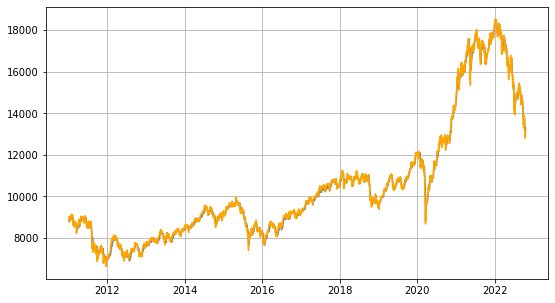

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(df1[2].shift(1), color='grey')
ax.plot(twse['還原收盤價']['2011':], color='orange')
ax.grid()
plt.show()

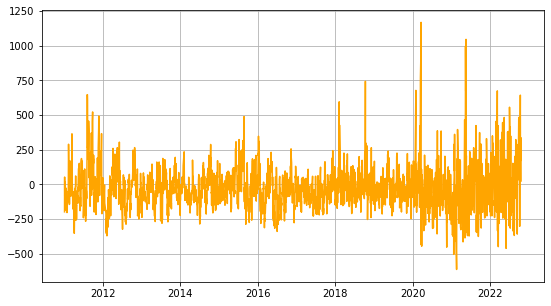

In [14]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(df1[2].shift(1) - twse['還原收盤價']['2011':], color='orange')
ax.grid()
plt.show()

In [15]:
(df1[2].shift(1) - twse['還原收盤價']['2011':]).groupby(pd.Grouper(freq='y')).describe()

,count,mean,std,min,25%,50%,75%,max
0,,,,,,,,
2011-12-31,246.0,15.220813,177.626208,-351.98,-118.2425,-19.260,115.5650,647.20
2012-12-31,250.0,-45.941040,133.951069,-369.91,-135.8825,-43.830,43.7200,305.34
2013-12-31,246.0,-40.332439,97.881269,-279.54,-111.4875,-33.925,21.4050,195.74
2014-12-31,248.0,-36.967823,95.506149,-284.96,-101.8900,-45.000,11.1950,288.61
2015-12-31,244.0,7.456025,119.650667,-286.92,-66.5825,-4.985,81.7575,489.66
2016-12-31,244.0,-47.888893,131.020808,-338.24,-129.1850,-53.595,35.3375,347.94
2017-12-31,246.0,-55.070366,88.382508,-226.84,-120.2575,-58.105,6.6025,244.24
2018-12-31,247.0,0.683036,121.376851,-252.13,-80.9550,-15.390,61.0150,743.89
2019-12-31,242.0,-29.217231,91.543018,-247.01,-91.4250,-34.010,20.1050,241.71


In [16]:

data = pd.concat([df1[2], twse['還原收盤價']['2011':], put['未平倉口數買賣淨額_put'], call['未平倉口數買賣淨額_call'], put['未平倉契約金額買賣淨額(千)_put'], call['未平倉契約金額買賣淨額(千)_call']], axis=1)


In [17]:
from IPython.display import display
## 找出周一到周五有甚麼不同效果
mon = data.resample('W-MON').ffill()
tue = data.resample('W-TUE').ffill()
wed = data.resample('W-WED').ffill()
thu = data.resample('W-THU').ffill()
fri = data.resample('W-FRI').ffill()
display((mon['還原收盤價'] - mon[2].shift(1)).describe())
display((tue['還原收盤價'] - tue[2].shift(1)).describe())
display((wed['還原收盤價'] - wed[2].shift(1)).describe())
display((thu['還原收盤價'] - thu[2].shift(1)).describe())
display((fri['還原收盤價'] - fri[2].shift(1)).describe())

count     616.000000
mean       25.376218
std       278.077631
min     -1796.110000
25%       -78.452500
50%        62.990000
75%       174.187500
max       818.430000
dtype: float64

count     615.000000
mean       26.252374
std       254.930204
min     -1660.370000
25%       -96.095000
50%        50.770000
75%       174.600000
max       790.290000
dtype: float64

count     615.000000
mean       27.660488
std       253.603996
min     -1781.330000
25%       -85.790000
50%        54.140000
75%       175.010000
max       819.980000
dtype: float64

count     615.000000
mean       31.203333
std       273.609127
min     -2218.660000
25%       -91.215000
50%        67.080000
75%       181.435000
max       936.360000
dtype: float64

count     615.000000
mean       29.852146
std       260.512682
min     -1365.910000
25%       -88.285000
50%        63.000000
75%       178.275000
max       813.950000
dtype: float64

In [18]:
wed[[2, '還原收盤價']]['2022'].diff(axis=1).describe()

C:\Users\ChastLai\AppData\Local\Temp\ipykernel_8008\3611843752.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  wed[[2, '還原收盤價']]['2022'].diff(axis=1).describe()


,2,還原收盤價
count,0.0,42.000000
mean,NaN,-13.195238
std,NaN,81.035761
min,NaN,-233.930000
25%,NaN,-73.800000
50%,NaN,-2.625000
75%,NaN,49.690000
max,NaN,121.590000


In [19]:
wed

,2,還原收盤價,未平倉口數買賣淨額_put,未平倉口數買賣淨額_call,未平倉契約金額買賣淨額(千)_put,未平倉契約金額買賣淨額(千)_call
2011-01-05,8800,8846.31,231015.0,240906.0,456206.0,1076693.0
2011-01-12,8900,8965.00,260342.0,282738.0,531022.0,1672168.0
2011-01-19,8900,9086.02,149786.0,176215.0,572015.0,1681161.0
2011-01-26,8900,9055.59,206637.0,204269.0,532496.0,1833118.0
2011-02-02,9000,9145.35,219332.0,230339.0,434539.0,2192656.0
...,...,...,...,...,...,...
2022-09-21,14500,14424.52,11037.0,4282.0,359161.0,-8544.0
2022-09-28,13700,13466.07,19890.0,8170.0,733739.0,21346.0
2022-10-05,13750,13801.43,29057.0,19621.0,542972.0,51777.0
2022-10-12,13150,13081.24,24879.0,26209.0,673816.0,54907.0


In [20]:
data.rename({2: 'MaxPain'}, inplace=True, axis=1)
data['差值'] = data.iloc[:, 1] - data.iloc[:, 0]
data.iloc[-20:, [1, 0, -1]]

,還原收盤價,MaxPain,差值
2022-09-20,14549.30,14600,-50.70
2022-09-21,14424.52,14500,-75.48
2022-09-22,14284.63,14350,-65.37
2022-09-23,14118.38,14250,-131.62
2022-09-26,13778.19,14000,-221.81
2022-09-27,13826.59,13950,-123.41
2022-09-28,13466.07,13700,-233.93
2022-09-29,13534.26,13550,-15.74
2022-09-30,13424.58,13450,-25.42
2022-10-03,13300.48,13400,-99.52


In [21]:
(data['還原收盤價'].shift(-1) - data['MaxPain'])#[(data.iloc[:, -1]).gt(data.iloc[:, -1].rolling(20).mean())].describe()

2011-01-03    197.19
2011-01-04    -53.69
2011-01-05     83.21
2011-01-06    -17.28
2011-01-07     17.88
               ...  
2022-10-12   -339.27
2022-10-13   -171.88
2022-10-14   -333.95
2022-10-17    -25.32
2022-10-18       NaN
Length: 2896, dtype: float64

In [22]:
(data['還原收盤價'].shift(-1) - data[2]).rolling(10).std().corr((put['未平倉契約金額買賣淨額(千)_put']).rolling(10).std())

KeyError: 2

In [ ]:
d1 = (data['還原收盤價'] - data['MaxPain'].shift(1)).rolling(10).std()
d2 = (data['未平倉契約金額買賣淨額(千)_put']).rolling(10).std()
d3 = (data['未平倉契約金額買賣淨額(千)_put'] - data['未平倉契約金額買賣淨額(千)_call'])
# d1 = (d1 - d1.rolling(200).mean()) / d1.rolling(200).std()
# d2 = (d2 - d2.rolling(200).mean()) / d2.rolling(200).std()

In [ ]:
d1.corr(d3)

0.5119726619949823

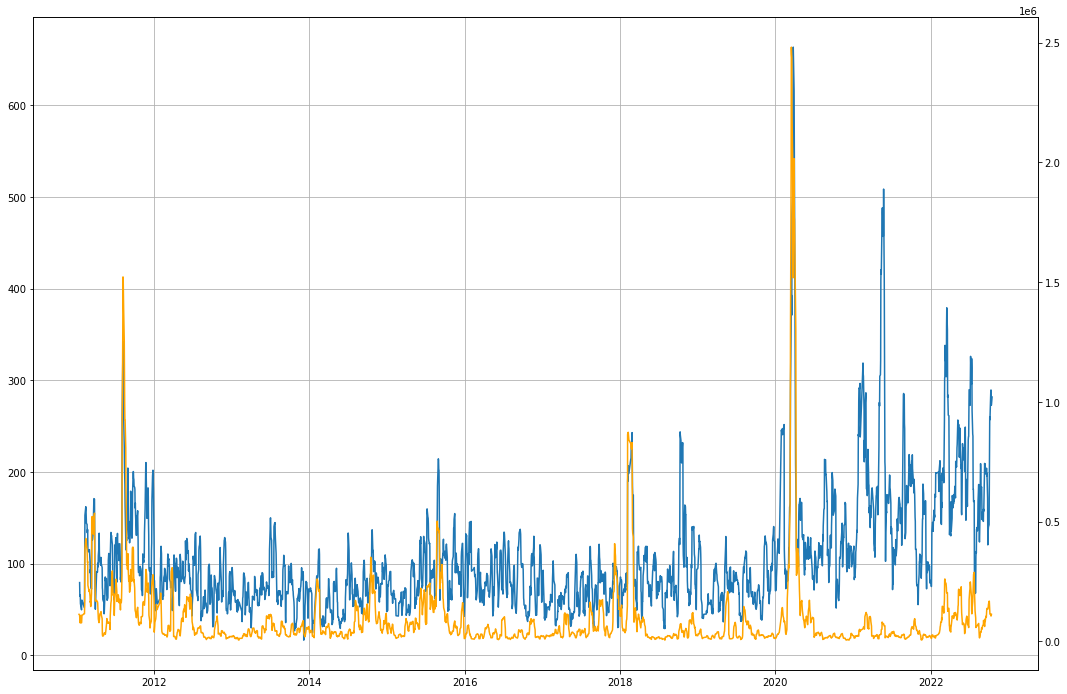

In [ ]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(d1)
ax1 = ax.twinx()
ax1.plot(d2, color='orange')
ax.grid()
plt.show()

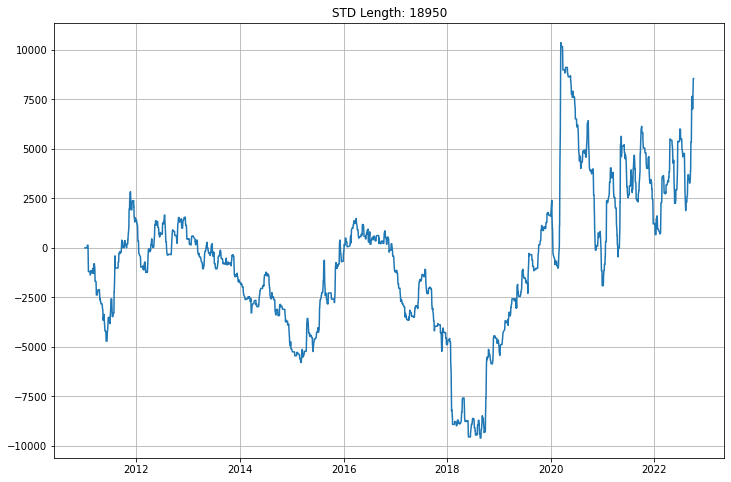

In [ ]:
# 對隔日波動的預期相關性 51% 
bs = []
#data = data / data.rolling(x).std()
for i in range(1, len(d2)):
    if (d2.iloc[i] > d2.iloc[i-1]) & (d3.iloc[i] < 100000):
        bs.append(1)
    elif (d2.iloc[i] > d2.iloc[i-1]) & (d3.iloc[i] > 100000):
        bs.append(-1)
    else:
        bs.append(0)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(((twse['還原收盤價'].shift(-5) - twse['還原開盤價']).shift(-2)['2011':] * bs).cumsum())
ax.set_title(f'STD Length: {x}')
ax.grid()
plt.show()

In [ ]:
d3

2011-01-03   -1323769.0
2011-01-04   -1104319.0
2011-01-05    -620487.0
2011-01-06    -709853.0
2011-01-07    -301012.0
                ...    
2022-10-12     618909.0
2022-10-13     703803.0
2022-10-14     493478.0
2022-10-17          NaN
2022-10-18          NaN
Length: 2896, dtype: float64

In [ ]:
d2

2011-01-03              NaN
2011-01-04              NaN
2011-01-05              NaN
2011-01-06              NaN
2011-01-07              NaN
                  ...      
2022-10-07    112966.375706
2022-10-11    113375.813267
2022-10-12    105151.673967
2022-10-13    107462.373502
2022-10-14    112033.747325
Name: 未平倉契約金額買賣淨額(千)_put, Length: 2894, dtype: float64